In [1]:
# Imports
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # set which GPU to use when training on a system that has multiple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

# make it so that not all memory of the gpu is instantly allocated when training a model
if not tf.test.gpu_device_name():
    warnings.warn("No GPU found.")
else: 
    print('Default gpu device: {}' .format(tf.test.gpu_device_name()))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Default gpu device: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


2023-04-18 09:37:34.467750: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 09:37:34.514677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 09:37:34.517871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 09:37:34.517975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [2]:
def load_data(filename, resample=False, integer_timestamp=False):
    # Load in the data
    df = pd.read_csv(filename, parse_dates=['timestamp'])
    
    # drop nan values
    df = df.dropna()

    # set timestamp as index and drop timestamp column
    df.index = pd.to_datetime(df['timestamp'], format='%Y.%m.%d %H:%M:%S')
    df = df.drop(columns=['timestamp'])

    if(resample):
        # Resample the DataFrame to 4 minutes frequency if needed
        df = df.resample('4T').mean()
    if(integer_timestamp):
        # use if the timestamp is a integer
        to_datetime = lambda x: datetime.datetime.fromtimestamp(x/1000.0)
        df['timestamp'] = df['timestamp'].astype(float)
        df['timestamp'] = df['timestamp'].apply(to_datetime)


    return df

df = load_data(r'combined-data/generated_data.csv')
df_generated2 = load_data(r'combined-data/generated_data_2.csv')
df_night = load_data(r'combined-data/generated_data_nightWork.csv')


print(df_night)
print("done")

                     state
timestamp                 
2023-03-01 00:00:00    0.0
2023-03-01 00:04:00    0.0
2023-03-01 00:08:00    0.0
2023-03-01 00:12:00    0.0
2023-03-01 00:16:00    0.0
...                    ...
2023-05-10 00:52:00    0.0
2023-05-10 00:56:00    0.0
2023-05-10 01:00:00    0.0
2023-05-10 01:04:00    0.0
2023-05-10 01:08:00    0.0

[25200 rows x 1 columns]
done


In [3]:
# if data did not have a state column yet add it
# df['state'] = np.where(df['power'] > 5, 1, 0)
# df = df.drop(columns=['power']) # drop the power column if necessary

In [4]:
df.head()

,state
timestamp,
2023-03-01 00:00:00,0.0
2023-03-01 00:04:00,1.0
2023-03-01 00:08:00,1.0
2023-03-01 00:12:00,1.0
2023-03-01 00:16:00,1.0


In [5]:
df.describe()

,state
count,25200.000000
mean,0.306786
std,0.461169
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
def add_time_features(df):
    # add hour, minute, day of the week and month parameters
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    # df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

# add time features to the datasets
df = add_time_features(df)
df_generated2 = add_time_features(df_generated2)
df_night = add_time_features(df_night)

In [7]:
df.head()

,state,hour,minute,day_of_week,month
timestamp,,,,,
2023-03-01 00:00:00,0.0,0,0,2,3
2023-03-01 00:04:00,1.0,0,4,2,3
2023-03-01 00:08:00,1.0,0,8,2,3
2023-03-01 00:12:00,1.0,0,12,2,3
2023-03-01 00:16:00,1.0,0,16,2,3


In [8]:
df_generated2.head()

,state,hour,minute,day_of_week,month
timestamp,,,,,
2023-03-01 00:00:00,0.0,0,0,2,3
2023-03-01 00:04:00,0.0,0,4,2,3
2023-03-01 00:08:00,0.0,0,8,2,3
2023-03-01 00:12:00,0.0,0,12,2,3
2023-03-01 00:16:00,0.0,0,16,2,3


In [9]:
df_night = df_night.dropna()
df_night.head()

,state,hour,minute,day_of_week,month
timestamp,,,,,
2023-03-01 00:00:00,0.0,0,0,2,3
2023-03-01 00:04:00,0.0,0,4,2,3
2023-03-01 00:08:00,0.0,0,8,2,3
2023-03-01 00:12:00,0.0,0,12,2,3
2023-03-01 00:16:00,0.0,0,16,2,3


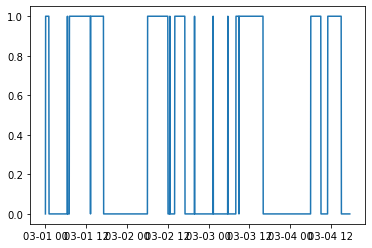

In [10]:
plt.plot(df['state'][0:1344])

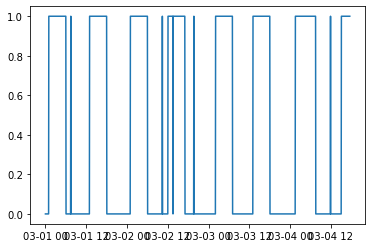

In [11]:
plt.plot(df_generated2['state'][0:1344])

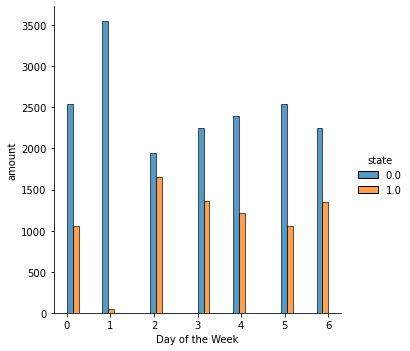

In [12]:
# plot the distribution of the state per day
sns.displot(df, x="day_of_week", hue="state", multiple="dodge")

# set x-axis label
plt.xlabel("Day of the Week")
plt.ylabel("amount")

# show plot
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# # normalize our features
scaler = MinMaxScaler(feature_range=(-1,1)) # use -1 to 1 for tanh, if using another activation fucntion other values might be better (e.g. the range
# of that activation function)
df_generated2[['hour','minute','day_of_week','month']] = scaler.fit_transform(df_generated2[['hour','minute','day_of_week','month']])
df_night[['hour','minute','day_of_week','month']] = scaler.transform(df_night[['hour','minute','day_of_week','month']])
df[['hour','minute','day_of_week','month']] = scaler.transform(df[['hour','minute','day_of_week','month']])
# save the scaler for use in the implementation
joblib.dump(scaler, './scaler_fake_transfer.gz')

print(df.head())
print(df_generated2.head())
print(df_night.head())

                     state  hour    minute  day_of_week  month
timestamp                                                     
2023-03-01 00:00:00    0.0  -1.0 -1.000000    -0.333333   -1.0
2023-03-01 00:04:00    1.0  -1.0 -0.857143    -0.333333   -1.0
2023-03-01 00:08:00    1.0  -1.0 -0.714286    -0.333333   -1.0
2023-03-01 00:12:00    1.0  -1.0 -0.571429    -0.333333   -1.0
2023-03-01 00:16:00    1.0  -1.0 -0.428571    -0.333333   -1.0
                     state  hour    minute  day_of_week  month
timestamp                                                     
2023-03-01 00:00:00    0.0  -1.0 -1.000000    -0.333333   -1.0
2023-03-01 00:04:00    0.0  -1.0 -0.857143    -0.333333   -1.0
2023-03-01 00:08:00    0.0  -1.0 -0.714286    -0.333333   -1.0
2023-03-01 00:12:00    0.0  -1.0 -0.571429    -0.333333   -1.0
2023-03-01 00:16:00    0.0  -1.0 -0.428571    -0.333333   -1.0
                     state  hour    minute  day_of_week  month
timestamp                                              

In [14]:
def split_train_test(df):
    train_size = int(len(df) * 0.8)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    return train, test

# split the datasets into training and testing sets
train, test = split_train_test(df)
train_sille, test_sille = split_train_test(df_generated2)
train_night, test_night = split_train_test(df_night)

# print the size of the training and testing sets for each dataset
print(len(train), len(test))
print(len(train_sille), len(test_sille))
print(len(train_night), len(test_night))

20160 5040
20160 5040
20160 5040


In [15]:
# shape of training and shape of test
train.shape, test.shape

((20160, 5), (5040, 5))

In [16]:
# function to create the input and output pairs for the lstm
def create_dataset(input, output, time_steps=1):
    x,y = [], []
    for i in range(len(input) - time_steps):
        v = input.iloc[i:(i + time_steps)].values
        x.append(v)
        y.append(output.iloc[i + time_steps])
    return np.array(x), np.array(y)

In [17]:
time_steps = 2520 # 4 minutes for 1 week = 2520, 1 hour 168, 30 minutes 336, 15 minutes 672
# how far to lookback we used one week

from sklearn import preprocessing

input_train, output_train = create_dataset(train,train.state,time_steps)
input_test, output_test = create_dataset(test,test.state,time_steps)

input_train_sille, output_train_sille = create_dataset(train_sille,train_sille.state,time_steps)
input_test_sille, output_test_sille = create_dataset(test_sille,test_sille.state,time_steps)

input_train_night, output_train_night = create_dataset(train_night,train_night.state,time_steps)
input_test_night, output_test_night = create_dataset(test_night,test_night.state,time_steps)

# print the shapes of the inputs
print(input_train.shape, input_test.shape, output_train.shape, output_test.shape)

(17640, 2520, 5) (2520, 2520, 5) (17640,) (2520,)


In [18]:
# custom activation function
# the swish activation function
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation

def custom_activation(x, beta = 1):
        return (K.sigmoid(beta * x) * x)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [19]:
model = Sequential()
model.add(Bidirectional(LSTM(32, input_shape=(input_train.shape[1],input_train.shape[2]),return_sequences=True,activation='tanh')))

# model.add(Activation(custom_activation,name = "Swish")) # only when using the swish activation function
# model.add(Dropout(0.25))
model.add(
    Bidirectional(LSTM(16,activation='tanh',return_sequences=True))
)
# model.add(Dropout(rate=0.25))
model.add(
    Bidirectional(LSTM(16,activation='tanh'))
)
# model.add(Activation(custom_activation,name = "Swish2")) # only when using the swish activation function
# model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.compile(loss='mse',optimizer=Adam(learning_rate=0.001))

In [20]:
history = model.fit(input_train, output_train, epochs=10,batch_size=32)
model.summary()

2023-04-18 09:37:43.224013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-04-18 09:37:47.013322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-04-18 09:37:47.495230: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


552/552 [==============================] - 122s 213ms/step - loss: 0.0167
Epoch 2/10
552/552 [==============================] - 117s 212ms/step - loss: 0.0103
Epoch 3/10
552/552 [==============================] - 117s 212ms/step - loss: 0.0089
Epoch 4/10
552/552 [==============================] - 117s 212ms/step - loss: 0.0082
Epoch 5/10
552/552 [==============================] - 117s 212ms/step - loss: 0.0079
Epoch 6/10
552/552 [==============================] - 117s 212ms/step - loss: 0.0077
Epoch 7/10
552/552 [==============================] - 117s 213ms/step - loss: 0.0075
Epoch 8/10
552/552 [==============================] - 117s 213ms/step - loss: 0.0074
Epoch 9/10
552/552 [==============================] - 117s 213ms/step - loss: 0.0073
Epoch 10/10
552/552 [==============================] - 117s 213ms/step - loss: 0.0073
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirect

In [21]:
# prediction on test data
prediction = model.predict(input_test)
from sklearn.metrics import mean_squared_error as mse
print(np.sqrt(mse(output_test,prediction)))


0.07818920909459261


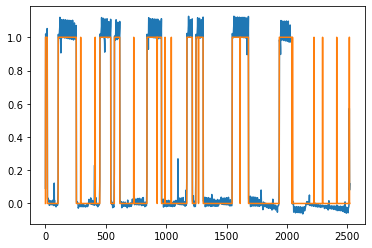

In [22]:
# comparison of predicted and actual
plt.plot(prediction[0:2520])
plt.plot(output_test[0:2520])

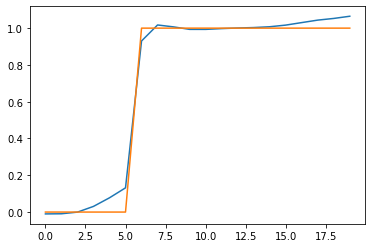

In [23]:
# zoom in on point where the state changes
plt.plot(prediction[100:120])
plt.plot(output_test[100:120])

# Transfer learning using another dataset with a different pattern

In [24]:
history = model.fit(input_train_sille, output_train_sille, epochs=10,batch_size=32)
model.summary()

Epoch 1/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0073
Epoch 2/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0068
Epoch 3/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0065
Epoch 4/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0063
Epoch 5/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0066
Epoch 6/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0060
Epoch 7/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0060
Epoch 8/10
552/552 [==============================] - 117s 213ms/step - loss: 0.0061
Epoch 9/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0060
Epoch 10/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0059
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param # 

In [25]:
prediction_sille = model.predict(input_test_sille)
from sklearn.metrics import mean_squared_error as mse
print(np.sqrt(mse(output_test_sille,prediction_sille)))


0.07330762043998794


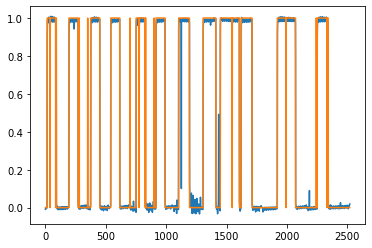

In [26]:
plt.plot(prediction_sille[0:2520])
plt.plot(output_test_sille[0:2520])

In [27]:
# prediction using the original pattern
prediction = model.predict(input_test)
from sklearn.metrics import mean_squared_error as mse
print(np.sqrt(mse(output_test,prediction)))

0.08218842208890924


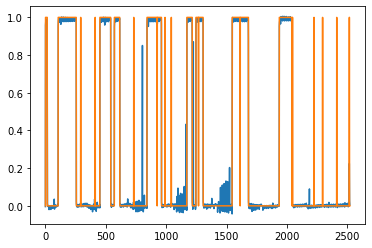

In [28]:
plt.plot(prediction[0:2520])
plt.plot(output_test[0:2520])

In [29]:
# transfer learning using yet another pattern
history = model.fit(input_train_night, output_train_night, epochs=10,batch_size=32)
model.summary()

Epoch 1/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0122
Epoch 2/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0059
Epoch 3/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0058
Epoch 4/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0057
Epoch 5/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0057
Epoch 6/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0057
Epoch 7/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0056
Epoch 8/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0056
Epoch 9/10
552/552 [==============================] - 118s 213ms/step - loss: 0.0056
Epoch 10/10
552/552 [==============================] - 118s 214ms/step - loss: 0.0055
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param # 

In [30]:
# prediction on previous pattern
prediction_sille = model.predict(input_test_sille)
from sklearn.metrics import mean_squared_error as mse
print(np.sqrt(mse(output_test_sille,prediction_sille)))

0.13716813758391055


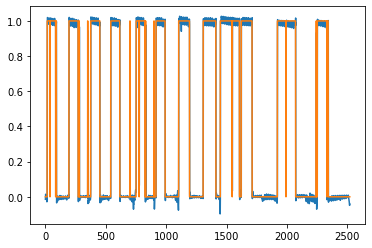

In [31]:
plt.plot(prediction_sille[0:2520])
plt.plot(output_test_sille[0:2520])

In [32]:
# prediction on original pattern
prediction = model.predict(input_test)
from sklearn.metrics import mean_squared_error as mse
print(np.sqrt(mse(output_test,prediction)))

0.13213070394671633


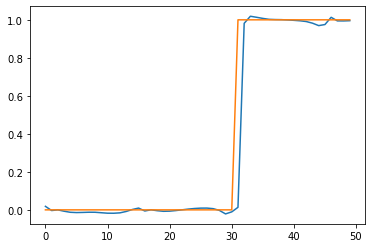

In [33]:
plt.plot(prediction[75:125])
plt.plot(output_test[75:125])

In [34]:
# save the model
model.save('./saved_models/models_day_month/statePrediction_scaled_transfer_triple/')
# !tar chvfz notebook.tar.gz 

2023-04-18 10:37:18.812587: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/models_day_month/statePrediction_scaled_transfer_triple/assets


INFO:tensorflow:Assets written to: ./saved_models/models_day_month/statePrediction_scaled_transfer_triple/assets


In [35]:
# save the notebook
!tar chvfz models_day_month.tar.gz ./saved_models/models_day_month*

./saved_models/models_day_month/
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/keras_metadata.pb
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/saved_model.pb
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/assets/
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/variables/
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/variables/variables.index
./saved_models/models_day_month/statePrediction_scaled_transfer_swish_sigmoid_3_datasets/variables/variables.data-00000-of-00001
./saved_models/models_day_month/fake_prediction_state_synthetic/
./saved_models/models_day_month/fake_prediction_state_synthetic/keras_metadata.pb
./saved_models/models_day_month/fake_prediction_state_synthetic/saved_model.pb

In [36]:
# backup of entire jupyterhub if needed
!tar chvfz jupyter_backup.tar.gz ../../../shared/